In [1]:
using ForwardDiff, Plots, LinearAlgebra

# Introduction

__Task__: Given observations $y$, find a plausible explanation for data generative process.

__Methodology__: Assume a data generative process $p(y,\theta)$ with unknown model parameters $\theta$ and estimate them. In case analytical solution does not exist or is costly, resort to iterative methods.

__Metric__: Define a cost function $\mathcal{J}(\theta)$ to assess estimations.

# Unconstrained Optimization Recap 

Step size is arranged properly, gradient descent approaches to a local minima (global minimum in case the function is convex). Newton's method uses an additional curvature information for faster convergence. However, Newton's method is attracted by saddle points not local minima. An example adopted from "Deep learning" book by Goodfellow is given below. 

$\mathcal{J}(\theta) = \theta_1^2 - \theta_2^2$

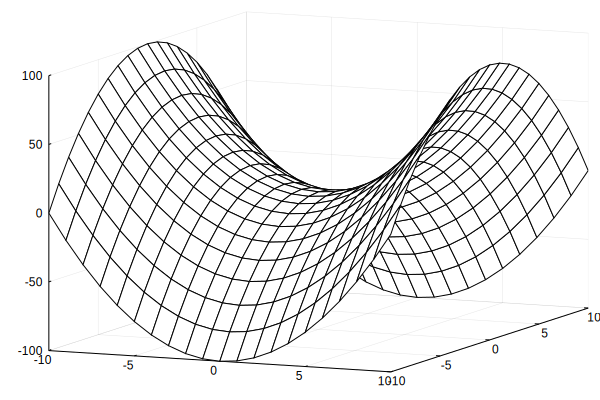

In [2]:
# Define a nonconvex function
nonconvexEx(x1,x2) = x1^2 - x2^2
nonconvexEx(x) = x[1]^2 - x[2]^2
x1 = -10:10
x2 = x1
plt = plot(x1, x2, nonconvexEx, linetype=:wireframe)

## Gradient Descent

$$
\theta \leftarrow \theta - \epsilon \cdot \nabla_\theta \mathcal{J}(\theta)
$$

┌ Info: Saved animation to 
│   fn = /Users/semihakbayrak/Codes/MachineLearning/Notes/gradDes.gif
└ @ Plots /Users/semihakbayrak/.julia/packages/Plots/XpHkc/src/animation.jl:98


Plots.AnimatedGif("/Users/semihakbayrak/Codes/MachineLearning/Notes/gradDes.gif")
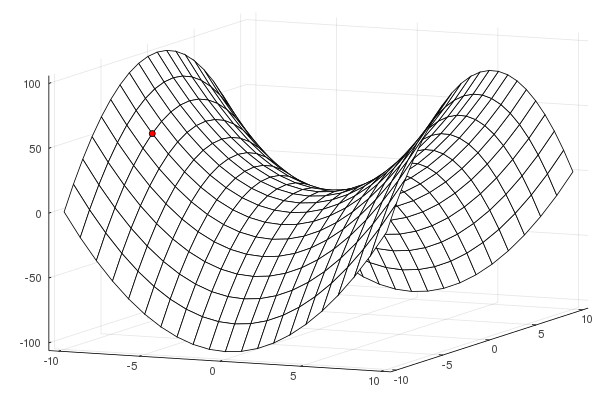

In [3]:
step_size = 0.01
global x = [-8,-4] #initial points

plot(x1, x2, nonconvexEx, linetype=:wireframe)

grad(x) = ForwardDiff.gradient(nonconvexEx,x)

#take 30 steps
anim = @animate for i=1:31
    plot!([x[1]],[x[2]],[nonconvexEx(x)],seriestype = :scatter,color=:red,label=false)
    global x = x - step_size*grad(x)
end
gif(anim, "gradDes.gif", fps = 5)

## Newton's Method

$$
\theta \leftarrow \theta - H^{-1} \cdot \nabla_\theta \mathcal{J}(\theta)
$$
where $H$ stands for Hessian of $\mathcal{J}$ evaluated at $\theta^{old}$

One can consider $H^{-1}$ as an adjusted step size that takes curveture information into account for stable convergence. Note that Newton's method is based on local quadratic (second order Taylor series) approximation of the function. Intuitively, Newton's method takes smaller steps in the directions with high curvetures since the function is more sensitive to changes in these directions. In case the function is locally quadratic, Newton's step will converge in one step. Otherwise, it can converge iteratively. Unlike gradient descent, Newton's method does not guarantee the convergence to local minima. For this to happen, Hessian must be positive definite. Otherwise it will converge to the closest stationary point which can be a maxima or a saddle point.

┌ Info: Saved animation to 
│   fn = /Users/semihakbayrak/Codes/MachineLearning/Notes/NewtonStep.gif
└ @ Plots /Users/semihakbayrak/.julia/packages/Plots/XpHkc/src/animation.jl:98


Plots.AnimatedGif("/Users/semihakbayrak/Codes/MachineLearning/Notes/NewtonStep.gif")
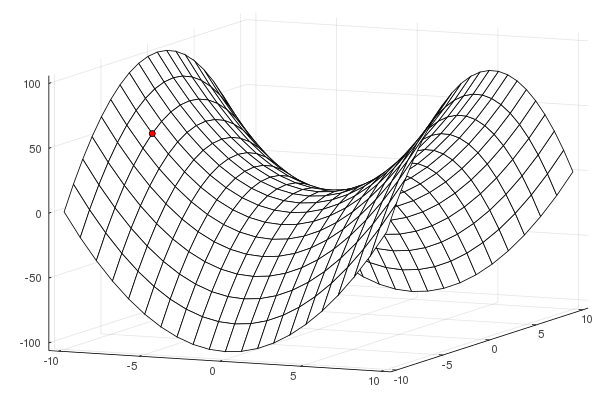

In [4]:
step_size = 0.1
global x = [-8,-4] #initial points

plot(x1, x2, nonconvexEx, linetype=:wireframe)

grad(x) = ForwardDiff.gradient(nonconvexEx,x)
Hessian(x) = ForwardDiff.hessian(nonconvexEx,x)

#take 30 steps
anim = @animate for i=1:31
    plot!([x[1]],[x[2]],[nonconvexEx(x)],seriestype = :scatter,color=:red,label=false)
    global x = x - step_size*inv(Hessian(x))*grad(x)
end
gif(anim, "NewtonStep.gif", fps = 5)

The above example converges in one step. In order to show the progress over time, an additional step size term is introduced.

This behaviour of Newton's method can be better understood if its eigenvalue analysis is made. First of all, $H$ is a real, symmetric matrix which implies that its eigenvalues are real and corresponding eigenvectors are perpendicular. Therefore, the gradient must be a linear combination of these eigenvectors since they span the entire space in dim($\theta$). For dim($\theta$) = d, the gradient is then $\nabla_\theta \mathcal{J}(\theta) = \sum\limits_{i=1}^{d} a_i \cdot v_i $ where $v_j$ is the jth eigenvector of $H$. Thus $H^{-1} \cdot \nabla_\theta \mathcal{J}(\theta) = \sum\limits_{i=1}^{d} \frac{a_i}{\lambda_i} \cdot v_i$ where $\lambda_j$ is the corresponding eigenvalue for $v_j$. Assume that at least one of the eigenvalues is negative. It will change the update direction due to gradient and push it towards the closest stationary point as the example above.

evals = [-2.0, 2.0]
evecs = [0.0 1.0; 1.0 0.0]


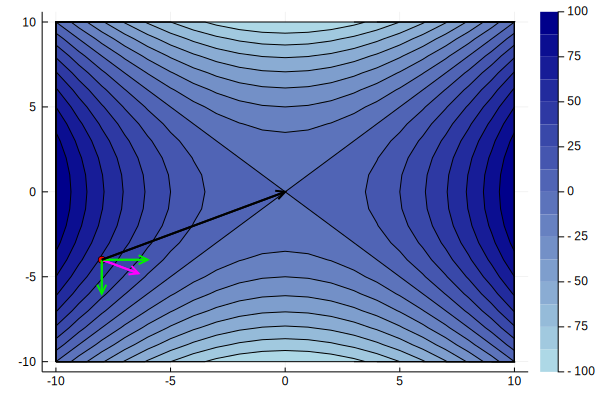

In [5]:
grad(x) = ForwardDiff.gradient(nonconvexEx,x)
Hessian(x) = ForwardDiff.hessian(nonconvexEx,x)

x = [-8,-4] #initial points
g_x = grad(x)
H_x = Hessian(x)
evals = eigvals(H_x)
evecs = eigvecs(H_x)
@show evals
@show evecs
N_dir = -inv(H_x)*g_x

contour(x1, x2, nonconvexEx,fill=true,color=:blues)
plot!([x[1]],[x[2]],seriestype = :scatter,color=:red,label=false)
quiver!([x[1]],[x[2]],quiver=([(-0.1*g_x[1],-0.1*g_x[2])]),lw=2,color=:magenta)
quiver!([x[1],x[1]],[x[2],x[2]],quiver=([(evals[1]*evecs[1,1],evals[1]*evecs[2,1]),(evals[2]*evecs[1,2],evals[2]*evecs[2,2])]),lw=2,color=:green2)
quiver!([x[1]],[x[2]],quiver=([(N_dir[1],N_dir[2])]),lw=2,color=:black)

Above, the update direction with gradient descent is shown with magenta. Green arrows indicate two eigenvectors multiplied with corresponding eigenvalues. As it can be seen the eigenvector with negative eigenvalue will change the direction of update when Newton's method is applied. The black arrow is the Newton step which converges to saddle point in one step.

# Natural Gradient Descent

Consider an objective to be optimized due to a probabilistic model. This objective is usually negative log-likelihood as it is in the original paper. The task is estimating model parameters such that the objective is optimized. Gradient descent is the most popular iterative technique. However, its performance depends on the parameterization of the model (such as mean-variance and mean-precision parameterizations of Gaussian) and degrades as the gradient vary in magnitudes from direction to direction.

Natural gradient optimization addresses this issue by making optimization in distribution space instead of parameters space. This means that closeness is not defined with Euclidean distance anymore but with KL divergence.

For more information read the followings:

1) "Why Natural Gradient?" By Amari and Doglas

2) "New insights and perspectives on the natural gradient method" by Martens

3) "Fisher information matrix", https://wiseodd.github.io/techblog/2018/03/11/fisher-information/, by Agustinus Kristiadi

4) "Natural gradient descent", https://wiseodd.github.io/techblog/2018/03/14/natural-gradient/, by Agustinus Kristiadi 

Natural gradient update is

$$
\theta \leftarrow \theta - \epsilon \cdot F^{-1} \cdot \nabla_\theta \mathcal{J}(\theta)
$$
where $F$ is the Fisher information matrix.

## Fisher Information Matrix

Following the common approach, we use log-likelihood $\log p(y|\theta)$ to measure how well the parameter $\theta$ fit to observations $y$. Here $\mathcal{J}(\theta)$ is negative log-likelihood $-\log p(y|\theta)$. We call $\nabla_\theta \log p(y|\theta)$ score function and Fisher information is its covariance 

$$
F = \mathbb{E}_{p(y|\theta)}[\nabla_\theta \log p(y|\theta) \cdot \nabla_\theta \log p(y|\theta)^{T}]
$$

Note that the optimization direction is determined by the score function, expected value of which is zero https://en.wikipedia.org/wiki/Score_(statistics). The sensitivity of the cost to this direction, on the other hand, is hidden in the covariance matrix of this gradient (Fisher information matrix).

Since it is usually difficult to evaluate this expectation, empirical Fisher information often replaces it in practice.

$$
F = \frac{1}{N} \sum\limits_{n=1}^{N} \nabla_\theta \log p(y_n|\theta) \cdot \nabla_\theta \log p(y_n|\theta)^{T}
$$
for i.i.d. $y$

Another interpretation of Fisher matrix is that it is the negative expected Hessian of log-likelihood:

$$
F = - \mathbb{E}_{p(y|\theta)}[H_{\theta}(\log p(y|\theta))]
$$

So, natural gradient descent employs the curvature information like Newton's method. A major difference between two methods is that Fisher information matrix is always positive definite unlike Hessian. This is because Fisher matrix is expectation of outer products of two vectors. Therefore, natural gradient descent does not require a local convexity to converge to local minima.

__Note__: To better understand how it is related to distribution space and KL divergences, formulate the task as an optimization of a probabilistic performance metric constrained to a divergence in $p(y|\theta)$. 

# Online Natural Gradient as a Kalman Filter

- Online Natural Gradient as a Kalman Filter by Yann Ollivier

Consider a set of input-output pairs ${(u_1,y_1),(u_2,y_2),...,(u_T,y_T)}$. The task is to estimate the parameters of the model $p(y|u,\theta)$. Natural gradient descent can be applied in a full stochastic setting as the following:

$$
F_t \leftarrow (1-\gamma_t) \cdot F_{t-1} + \gamma_t \cdot \mathbb{E}_{p(y|u_t,\theta_{t-1})}[\nabla_\theta \log p(y|u_t,\theta_{t-1}) \cdot \nabla_\theta \log p(y|u_t,\theta_{t-1})^{T}]
\\
\theta_t \leftarrow \theta_{t-1} - \epsilon_t \cdot F_t^{-1} \cdot \nabla_\theta \mathcal{J}(\theta)
$$

where $\gamma_t$ is Fisher decay rate.

For this to converge well, $\theta$ must change slowly. This is because Fisher updates at each time step depends on a different $\theta$ value. Additionally, $\epsilon$ and $\gamma$ must satisfy the Robins-Monro conditions.

## Information Filter

We now cast the above stochastic approach as a simple information filter with zero transition noise. Details, proofs and further extensions such as better step size specifications with noise injection in transition are given in the paper.

$$
p(\theta_t|\theta_{t-1}) = \mathcal{N}(\theta_t;\theta_{t-1},0)
\\
p(y_t|u_t,\theta_t) = \mathcal{N}(y_t;\hat{y}_t,R_t)
\\
\hat{y}_t = g(u_t,\theta_{t})
$$
where $g(u_t,\theta_{t})$ is a function of $u_t,\theta_{t}$. In this example $R_t$ is given. It is possible to extend this procedure to more complex model definitions such as unknown $R$ or multinomial likelihood, etc.

In [6]:
display("image/png", read("NGIF.png"))

Filtering for the given model is:

$$
W_{t} \leftarrow W_{t-1} + G_t^T \cdot R_t^{-1} \cdot G_t
\\
m_{t} \leftarrow m_{t-1} + K_t \cdot E_t
$$

where $m_t$ and $W_t$ are estimated mean and precision terms for $\theta_t$ i.e. $p(\theta_t|y_{1:t}) = \mathcal{N}(\theta_t;m_{t},W_{t}^{-1})$. $G_t$ is jacobian of $g(.,.)$ evaluated at $u_t$, $m_{t-1}$. $K_t$ and $E_t$ are Kalman gain and error at time $t$, respectively:

$$
E_t = y_t - \hat{y}_t
\\
K_t = V_{t-1} \cdot G_t^T \cdot (G_t V_{t-1} G_t^T + R_t)^{-1}
\\
V_t = (I - K_t G_t) V_{t-1}
$$

__Lemma__: $E_t = R_t \cdot \nabla_{\hat{y_t}} \log p(y_t|\hat{y_t})$

__Proof__: 
$
\log p(y|\hat{y}) \propto -0.5 (y-\hat{y})^{T} R^{-1} (y-\hat{y})
\\
\nabla_{\hat{y}} \log p(y|\hat{y}) = R^{-1} (y-\hat{y})
$

__Lemma__: $K_t R_t = V_t G_t^{T}$

__Proof__: 
$
K_t R_t = K_t (R_t + G_t V_{t-1} G_t^{T}) - K_t G_t V_{t-1} G_t^{T} 
\\
= V_{t-1} \cdot G_t^T \cdot (G_t V_{t-1} G_t^T + R_t)^{-1} (R_t + G_t V_{t-1} G_t^{T}) - K_t G_t V_{t-1} G_t^{T}
\\
= V_{t-1} \cdot G_t^T - K_t G_t V_{t-1} G_t^{T}
\\
= (I - K_t G_t) V_{t-1} \cdot G_t^T
\\
= V_t G_t^{T}
$

__ProPosition__: $m_t = m_{t-1} - V_t \cdot \nabla_{m_{t-1}} l(y_t)$ 

where $l(y_t) = -\log p(y_t|u_t,\theta_t)$

__Proof__: 
$
m_t = m_{t-1} + K_t E_t 
\\
m_t = m_{t-1} + K_t R_t \cdot \nabla_{\hat{y_t}} \log p(y_t|\hat{y_t})
\\
m_t = m_{t-1} + V_t G_t^{T} \cdot \nabla_{\hat{y_t}} \log p(y_t|\hat{y_t})
\\
\text{we adopt the convention where gradients are column vectors and partial derivative is row vector.}
\\
m_t = m_{t-1} + V_t G_t^{T} \cdot 
\left(\frac{\partial \log p(y_t|\hat{y_t})}{\partial \hat{y_t}}\right)^{T} 
\\
m_t = m_{t-1} + V_t \cdot 
\left(\frac{\partial \log p(y_t|\hat{y_t})}{\partial \hat{y_t}} \cdot G_t\right)^{T}
\\
m_t = m_{t-1} + V_t \cdot 
\left(\frac{\partial \log p(y_t|\hat{y_t})}{\partial \hat{y_t}} \cdot \frac{\partial \hat{y_t}}{\partial m_{t-1}} \right)^{T}
\\
m_t = m_{t-1} - V_t \cdot \nabla_{m_{t-1}} l(y_t)
$

__Lemma__: $G_t^T R_t^{-1} G_t$ is the Fisher information matrix of $y$ w.r.t. $m_{t-1}$

__Proof__: 
$
F_{m_{t-1}}(y_t) = - \mathbb{E}_{p(y|\hat{y})}[H_{m_{t-1}}(\log p(y_t|\hat{y}_t))]
\\
\text{Note that }
\frac{\partial \log p(y_t|\hat{y}_t)}{\partial m_{t-1}} = \frac{\partial \log p(y_t|\hat{y}_t)}{\partial y_t} \frac{\partial y_t}{\partial m_{t-1}}
\\
F_{m_{t-1}}(y_t) = - G_t^{T} \mathbb{E}_{p(y|\hat{y})}[H_{y_t}(\log p(y_t|\hat{y}_t))] G_t
\\
F_{m_{t-1}}(y_t) = - G_t^{T} \mathbb{E}_{p(y|\hat{y})}[H_{y_t}(-R_t^{-1})] G_t
\\
F_{m_{t-1}}(y_t) = G_t^{T} R_t^{-1} G_t
$

### Matching the terms to explore the relation

#### Online natural gradient

$$
F_t \leftarrow (1-\gamma_t) \cdot F_{t-1} + \gamma_t \cdot \mathbb{E}_{p(y|u_t,\theta_{t-1})}[\nabla_\theta \log p(y|u_t,\theta_{t-1}) \cdot \nabla_\theta \log p(y|u_t,\theta_{t-1})^{T}]
\\
\theta_t \leftarrow \theta_{t-1} - \epsilon_t \cdot F_t^{-1} \cdot \nabla_\theta \mathcal{J}(\theta)
$$

#### Extended Kalman filter

$$
W_{t} \leftarrow W_{t-1} + \mathbb{E}_{p(y|\hat{y})}[\nabla_m \log p(y|\hat{y}) \cdot \nabla_m \log p(y|\hat{y})^{T}]
\\
m_{t} \leftarrow m_{t-1} - W_{t}^{-1} \cdot \nabla_{m} l(y_t)
$$

Replacing $W_t$ with $(t+1)\cdot F_t$ and mean $m$ with random variable itself $\theta$:

$$
F_{t} \leftarrow \frac{t}{t+1} F_{t-1} + \frac{1}{t+1} \mathbb{E}_{p(y|\hat{y})}[\nabla_\theta \log p(y|\hat{y}) \cdot \nabla_\theta \log p(y|\hat{y})^{T}]
\\
\theta_{t} \leftarrow \theta_{t-1} - \frac{1}{t+1} F_{t}^{-1} \cdot \nabla_{\theta} l(y_t)
$$

which refers to online natural gradient where decay $\gamma_t$ and step size $\epsilon_t$ parameters equal to $1/(t+1)$

# Toy Example

In [7]:
using Random
Random.seed!(123);

In [8]:
T = 100 #number of instances
U = 10*randn(T,3)
theta_real = 10*randn(3,2)
Y = U*theta_real + 0.1*randn(T,2)
@show theta_real
;

theta_real = [4.580988032483541 13.519512876599222; 1.3912437753868148 -1.0631563189748174; -2.307450228368145 -2.0588258047347825]


In [9]:
#Model postulates unit variance in the likelihood function
log_p(y,u,theta) = -0.5 * transpose(y-transpose(theta)*u) * (y-transpose(theta)*u)
cost(y,u,theta) = -log_p(y,u,theta)
;

In [10]:
theta_initial = randn(3,2)

3×2 Array{Float64,2}:
 1.1793     0.0981294
 0.193039   1.15057  
 0.0419942  0.499533 

## Learning with Stochastic Gradient Descent

Since we will apply stochastic setting of gradient descent, the step sizes must satisfy the Robins and Monro's condition:

$
\sum\limits_{i=0}^{\infty} \epsilon_i = \infty, \qquad \sum\limits_{i=0}^{\infty} \epsilon_i^2 < \infty
$

To satisfy it, we specify the step size in the form of constant/$t$ as it is suggested by Robins and Monro https://en.wikipedia.org/wiki/Stochastic_approximation.

In [11]:
global theta = theta_initial

rmse = sum((theta_real-theta).^2)/2
rmse_list = [rmse]

for t=1:T
    step_size = 0.01/t
    y_t = Y[t,:]
    u_t = U[t,:]
    cost_theta(theta) = cost(y_t,u_t,theta)
    grad(theta) = ForwardDiff.gradient(cost_theta,theta) #computes partial derivative
    global theta = theta - step_size*grad(theta)
    #RMSE
    rmse = sum((theta_real-theta).^2)/2
    push!(rmse_list,rmse)
end

In [12]:
#Estimated and real theta
@show theta
@show theta_real
;

theta = [4.195779363227317 12.52150875406926; 1.421097237634222 -1.0381544261425983; -2.7859851915901683 -3.2607628389367878]
theta_real = [4.580988032483541 13.519512876599222; 1.3912437753868148 -1.0631563189748174; -2.307450228368145 -2.0588258047347825]


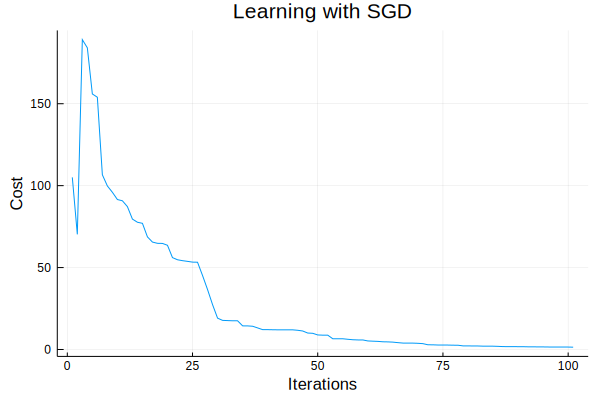

In [13]:
plot(rmse_list, xlabel = "Iterations", ylabel = "Cost", title="Learning with SGD", legend=false)

# Learning with Extended Kalman Filter

In [14]:
g(u,theta) = transpose(theta)*u;

In [15]:
global theta = theta_initial

rmse = sum((theta_real-theta).^2)/2
rmse_list = [rmse]

V = diagm(ones(6))
R = diagm(ones(2))
for t=1:T
    y_t = Y[t,:]
    u_t = U[t,:]
    y_hat_t = g(u_t,theta)
    E = y_t - y_hat_t
    g_theta(theta) = g(u_t,theta)
    G = ForwardDiff.jacobian(g_theta,theta)
    K = V*transpose(G)*inv(G*V*transpose(G)+R)
    V = (diagm(ones(6)) - K*G)*V
    global theta = theta + reshape(K*E,(3,2))
    #RMSE
    rmse = sum((theta_real-theta).^2)/2
    push!(rmse_list,rmse)
end

In [16]:
#Estimated and real theta
@show theta
@show theta_real
;

theta = [4.581031503750399 13.518740913363276; 1.392287844542594 -1.0623165019583771; -2.3084647492300614 -2.0579342252994812]
theta_real = [4.580988032483541 13.519512876599222; 1.3912437753868148 -1.0631563189748174; -2.307450228368145 -2.0588258047347825]


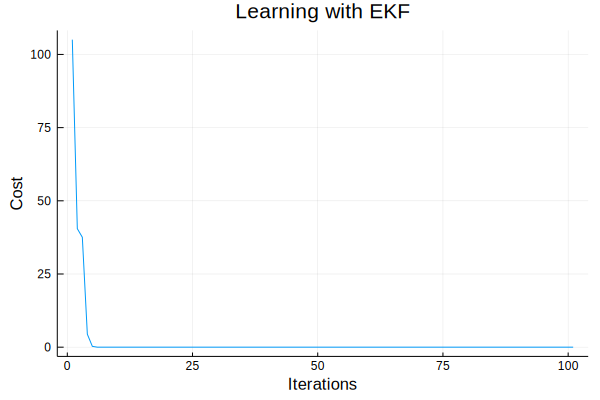

In [17]:
plot(rmse_list, xlabel = "Iterations", ylabel = "Cost", title="Learning with EKF", legend=false)